In [17]:
import scanpy as sc
import numpy as np
import torch

import os,sys
pwd = '/home/lijiahao/workbench/SAVE/'
sys.path.append(pwd)
os.chdir(pwd)

from model.save_model import SAVE
from model.utils.process_h5ad import batch_scale, preprocessing_rna

In [18]:
# download the data via link: https://figshare.com/ndownloader/files/24539828

In [19]:
adata = sc.read_h5ad('human_pancreas_norm_complexBatch.h5ad')
adata.obs["batch"] = adata.obs["tech"]
adata.obs["cell_type"] = adata.obs["celltype"]

In [20]:
adata = preprocessing_rna(adata, is_batch_scale=True)

/mnt/sdc/lijiahao/miniconda3/envs/SAVE/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:139: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['n_genes'] = number
batch_scale: 100%|████████████████████████████████| 1/1 [00:00<00:00,  3.58it/s]


In [21]:
device = torch.device('cuda:0')
seed = 1202
kwargs = {
    "device": device,
    "seed": seed,
    "is_data_scaled": True,
}
import yaml

with open(pwd + "/model_setting.yml", "r") as f:
    setting = yaml.safe_load(f)

kwargs.update(setting["SAVE-B"]["train"])
kwargs.update(setting["SAVE-B"]["model"])

In [22]:
from model.save_model import SAVE

save_model = SAVE(
    adata=adata.copy(),
    is_initialized=True,
    condition_cols=['batch'],
    **kwargs,
    )


total col comb is: 1
initialze model weight with seed 1202


In [23]:
save_model.train(**kwargs)
save_model.save_ckpt('ckpt/human_pancreas_norm_complexBatch.pt')

cond encoding max: 8 min:0
total iter: 3200


100%|██████| 200/200 [08:25<00:00,  2.53s/it, recon_loss=411.257,kl_loss=10.966]

save ckpt to ckpt/human_pancreas_norm_complexBatch2.pt!


In [24]:
save_model.load_ckpt('ckpt/human_pancreas_norm_complexBatch.pt')

successfully load ckpt/human_pancreas_norm_complexBatch2.pt!


In [25]:
latent = save_model.get_latent()

cond encoding max: 8 min:0


100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 17.16it/s]


In [26]:
adata.obsm['SAVE'] = latent

/mnt/sdc/lijiahao/miniconda3/envs/SAVE/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/mnt/sdc/lijiahao/miniconda3/envs/SAVE/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


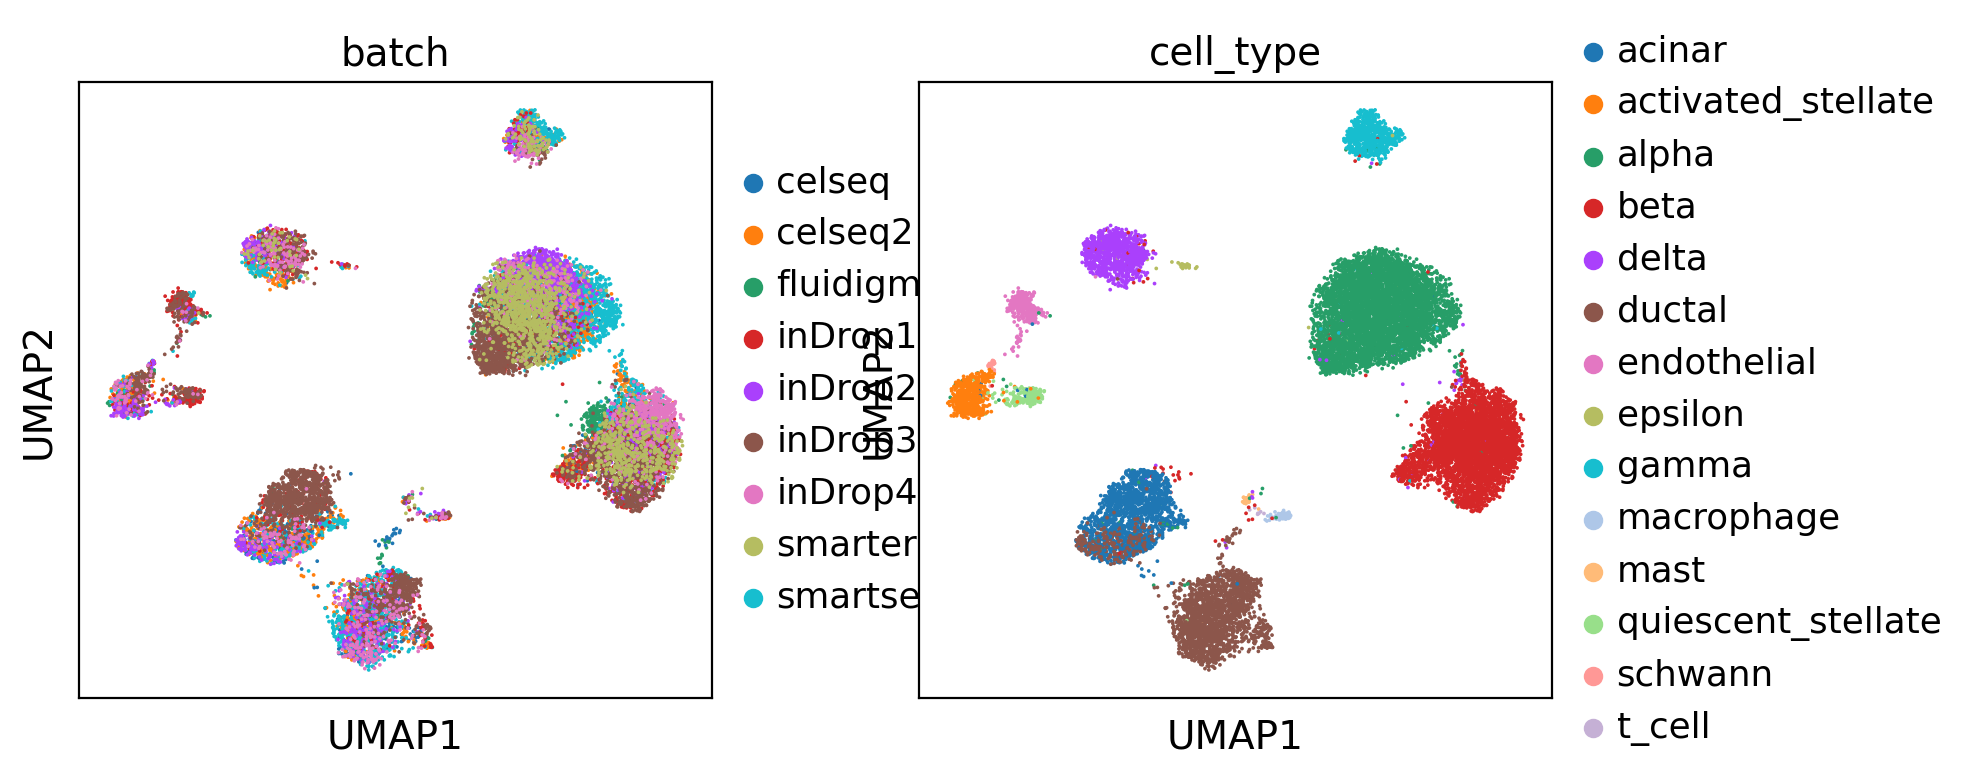

In [27]:
sc.set_figure_params(dpi=100)
sc.pp.neighbors(adata, use_rep="SAVE")
sc.tl.umap(adata)
sc.pl.umap(adata, color=['batch', 'cell_type'])

### scIB evaluation

In [28]:
from scib_metrics.benchmark import Benchmarker

In [29]:
sc.pp.pca(adata)
adata.obsm['Unintegraged'] = adata.obsm['X_pca']

In [30]:
bm = Benchmarker(
    adata=adata,
    batch_key='batch',
    label_key='cell_type',
    embedding_obsm_keys=['Unintegraged', 'SAVE'],
)

In [31]:
bm.benchmark()

Computing neighbors:   0%|          | 0/2 [00:00<?, ?it/s]

Embeddings:   0%|          | 0/2 [00:00<?, ?it/s]

INFO     t_cell consists of a single batch or is too small. Skip.                                                  


Embeddings:  50%|█████     | 1/2 [00:51<00:51, 51.28s/it]

INFO     t_cell consists of a single batch or is too small. Skip.                                                  


Embeddings: 100%|██████████| 2/2 [01:12<00:00, 36.31s/it]


In [32]:
res_df = bm.get_results(min_max_scale=False)
print(res_df)

               Isolated labels        KMeans NMI        KMeans ARI  \
Embedding                                                            
Unintegraged          0.507195          0.625248          0.401214   
SAVE                  0.627723            0.7653          0.654325   
Metric Type   Bio conservation  Bio conservation  Bio conservation   

              Silhouette label             cLISI  Silhouette batch  \
Embedding                                                            
Unintegraged          0.570027               1.0          0.857019   
SAVE                  0.604381               1.0          0.915104   
Metric Type   Bio conservation  Bio conservation  Batch correction   

                         iLISI              KBET Graph connectivity  \
Embedding                                                             
Unintegraged          0.001527           0.21603           0.730913   
SAVE                  0.217944          0.379716           0.899878   
Metric Type   